In [1]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

## ОБЛАСТЬ РАБОТЫ 1

Библиотеки и функции

In [2]:
# Данный блок в области 1 НЕ выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
# запрещается скрывать предупреждения системы
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
# pip install

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score

from sklearn.linear_model import LogisticRegression

import sklearn

In [4]:
def histmaker_for_numeric_df(df):
    """рисует хистплоты для каждого столбца датафрейма. 
    Если в дф-е есть столбцы, которые не нужно рисовать, их стоит удалить """
    #оставим только численные столбцы 
    cond = [np.issubdtype(df[f'{column}'], np.number) for column in df.columns]
    df = df[df.columns[cond]]
    
    sns.set(style='darkgrid', palette='deep')

    array_of_columns_of_df = df.values.T.tolist()

    num_plots = len(df.columns)         #количество графиков
    num_rows = (num_plots - 1) // 3 + 1 #количество строк 
    num_cols = min(num_plots, 3)        #количество столбцов

    fig, axes = plt.subplots(num_rows, num_cols, figsize = (15, 4*num_rows))
    plt.suptitle('Histograms of every column in your df', fontsize = 15)
    for i, ax in enumerate(axes.flat):
        col = (np.random.random (), np.random.random (), np.random.random ()) #случайный увет
        if i < num_plots:
            ax.hist(array_of_columns_of_df[i],
                    bins = 20,
                    edgecolor = 'black', color = col, alpha = 0.7)
            ax.set_title(df.columns[i], weight='bold')
        if i % 3 == 0:
            ax.set_ylabel('count')
    
    #Удаление пустых подграфиков
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])


## ОБЛАСТЬ РАБОТЫ 2

Поиск лучшей модели

**Загрузим данные и посмотрим на них**

In [5]:
wine = pd.read_csv('train.csv')
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.4,0.17,0.34,1.5,0.091,42.0,135.0,0.99380,3.25,0.49,9.6,7
1,8.0,0.42,0.36,5.0,0.037,34.0,101.0,0.99200,3.13,0.57,12.3,7
2,6.7,0.27,0.25,8.0,0.053,54.0,202.0,0.99610,3.22,0.43,9.3,5
3,5.2,0.21,0.31,1.7,0.048,17.0,61.0,0.98953,3.24,0.37,12.0,7
4,7.6,0.48,0.37,1.2,0.034,5.0,57.0,0.99256,3.05,0.54,10.4,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1720,6.9,0.39,0.22,4.3,0.030,10.0,102.0,0.99300,3.00,0.87,11.6,4
1721,6.4,0.34,0.10,1.1,0.048,19.0,84.0,0.99270,3.21,0.38,9.8,5
1722,7.0,0.53,0.43,6.1,0.029,6.0,76.0,0.99118,3.08,0.50,12.5,8
1723,5.9,0.17,0.29,3.1,0.030,32.0,123.0,0.98913,3.41,0.33,13.7,7


In [6]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000
mean,6.821797,0.283849,0.332545,5.725652,0.044460,34.615072,135.248116,0.993532,3.201449,0.492394,10.734348,6.004638
std,0.853886,0.106090,0.122279,4.570812,0.021236,16.751535,42.848854,0.002830,0.151395,0.121452,1.272796,1.071667
min,3.900000,0.085000,0.000000,0.600000,0.012000,3.000000,10.000000,0.987110,2.830000,0.220000,8.400000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.034000,23.000000,105.000000,0.991320,3.100000,0.400000,9.600000,5.000000
50%,6.800000,0.270000,0.320000,4.600000,0.041000,33.000000,130.000000,0.993200,3.190000,0.480000,10.600000,6.000000
75%,7.300000,0.330000,0.380000,8.700000,0.049000,45.000000,164.000000,0.995500,3.300000,0.560000,11.700000,7.000000
max,11.800000,1.100000,1.660000,20.700000,0.290000,124.000000,366.500000,1.001820,3.820000,1.080000,14.200000,9.000000


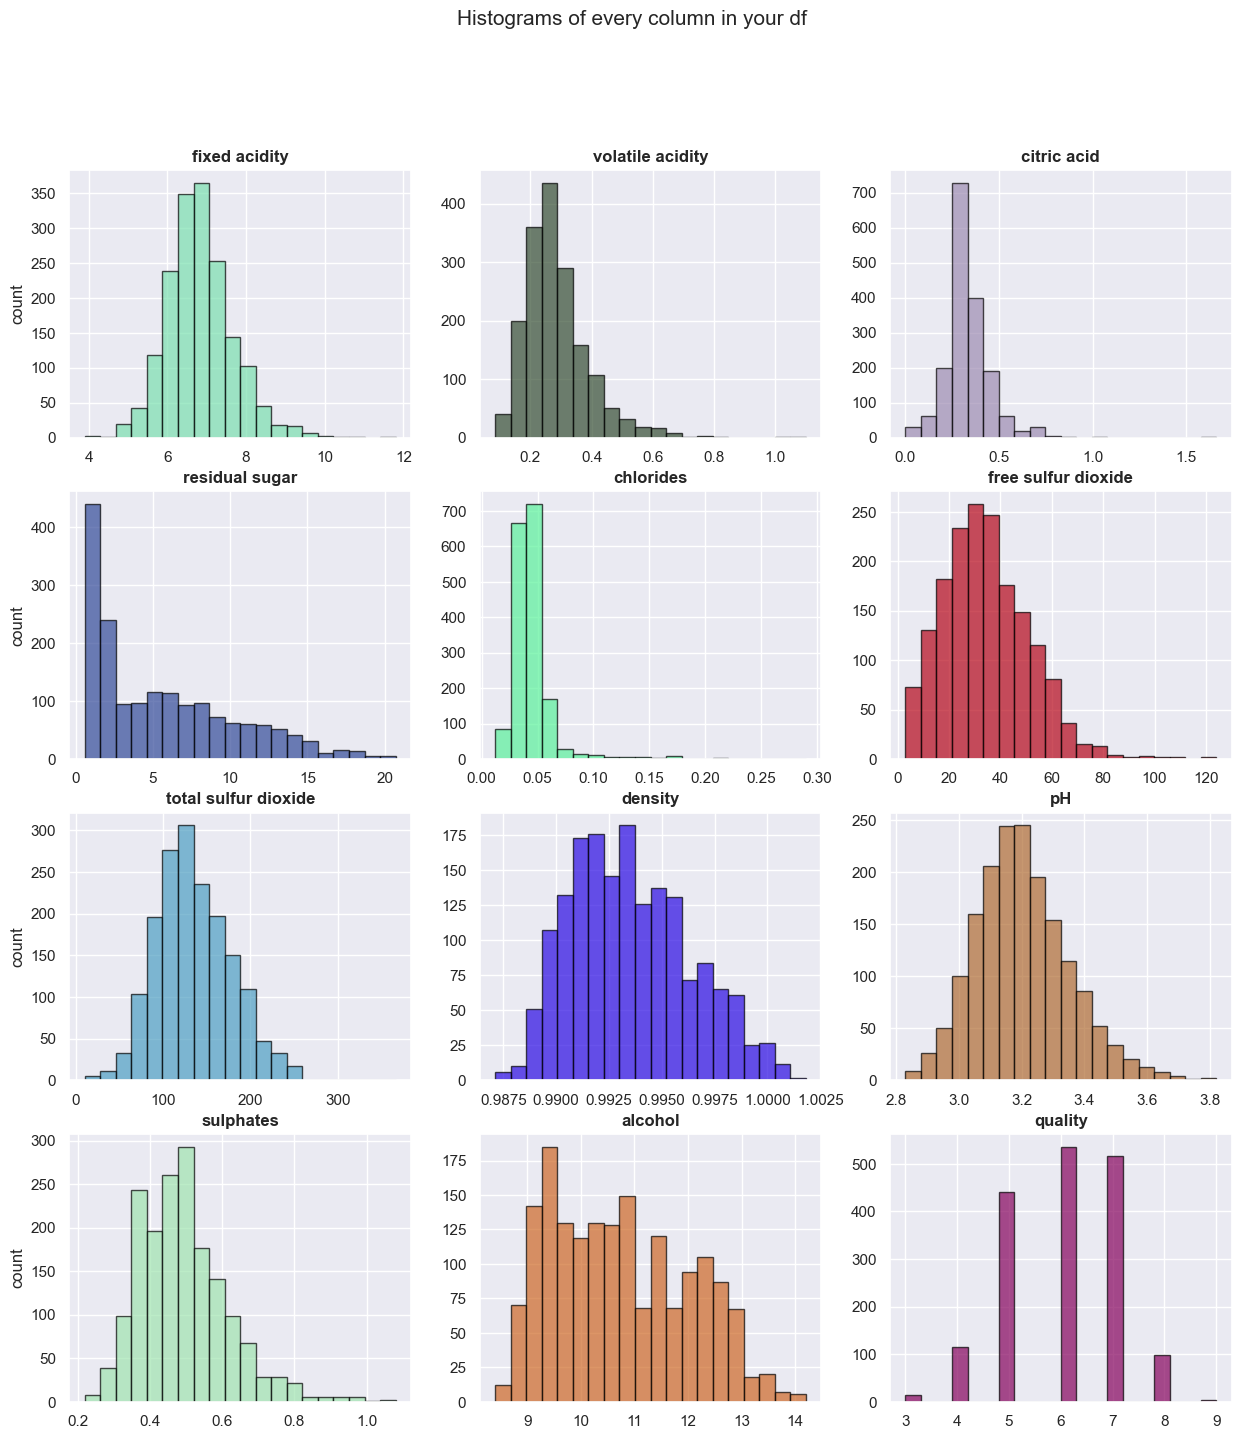

In [7]:
histmaker_for_numeric_df(wine)

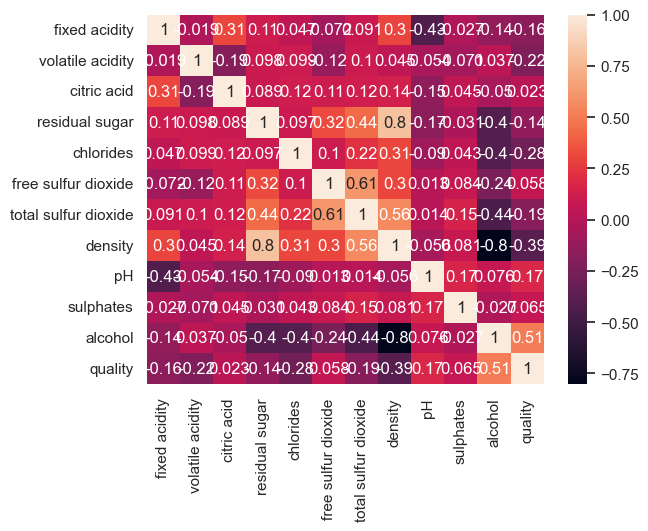

In [8]:
dataplot = sns.heatmap(wine.corr(), annot = True)

In [9]:
wine = wine.drop(columns = ['density'])

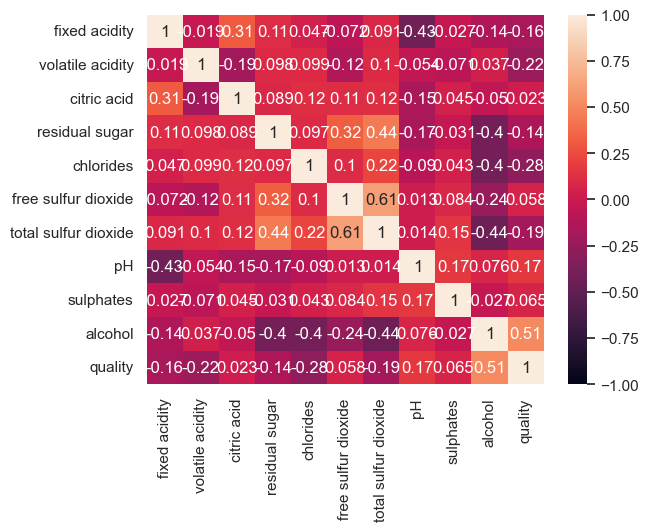

In [10]:
dataplot = sns.heatmap(wine.corr(), annot = True,vmin=-1, vmax=1)

In [11]:
wine['quality'] = np.where(wine.quality >= 7, 1, 0)
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality
0,6.4,0.17,0.34,1.5,0.091,42.0,135.0,3.25,0.49,9.6,1
1,8.0,0.42,0.36,5.0,0.037,34.0,101.0,3.13,0.57,12.3,1
2,6.7,0.27,0.25,8.0,0.053,54.0,202.0,3.22,0.43,9.3,0
3,5.2,0.21,0.31,1.7,0.048,17.0,61.0,3.24,0.37,12.0,1
4,7.6,0.48,0.37,1.2,0.034,5.0,57.0,3.05,0.54,10.4,0
...,...,...,...,...,...,...,...,...,...,...,...
1720,6.9,0.39,0.22,4.3,0.030,10.0,102.0,3.00,0.87,11.6,0
1721,6.4,0.34,0.10,1.1,0.048,19.0,84.0,3.21,0.38,9.8,0
1722,7.0,0.53,0.43,6.1,0.029,6.0,76.0,3.08,0.50,12.5,1
1723,5.9,0.17,0.29,3.1,0.030,32.0,123.0,3.41,0.33,13.7,1


In [12]:
# доля классов в изначальных данных
wine['quality'].mean()
#количество классов неравномерное

0.3582608695652174

**Разделим выборку на тест и трейн**

In [13]:
wine_target = np.array(wine['quality'].values)
wine_date = wine.drop(columns = ['quality'])




In [14]:
X_train, X_test, y_train, y_test = train_test_split(wine_date, wine_target, stratify = wine_target, test_size=0.3)


**Подберем число соседей**

In [15]:
# Объявление контейнера
pipe = Pipeline([('preprocessing', RobustScaler()), 
                 ('classifier',    KNeighborsClassifier())])

# Объявление кросс-валидации
kfold = KFold(n_splits=10, shuffle=True)

# Объявление параметров гридсерча
p = np.arange(1,4)
n_neighbors = np.arange(90, 150)
scaling = [MinMaxScaler(), StandardScaler(),RobustScaler()]

# Засунем параметры гридсерча в него
param_grid =[
    {'preprocessing': scaling, 
     'classifier': [KNeighborsClassifier()],
         'classifier__n_neighbors': n_neighbors,
         'classifier__p': p,
         'classifier__weights': ['uniform','distance']
     }]

grid = GridSearchCV(pipe, param_grid, cv=kfold, scoring = 'roc_auc')
grid.fit(X_train,y_train)
grid

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing', RobustScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid=[{'classifier': [KNeighborsClassifier(n_neighbors=92,
                                                              p=1,
                                                              weights='distance')],
                          'classifier__n_neighbors': array([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149]),
                          'classifier__p': array([1, 2, 3]),
                          'classifier__weights': ['uniform', 'distance'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler()]}],
             scoring='roc_auc')

In [16]:
#sklearn.metrics.get_scorer_names()

In [17]:
# тестовый скор
grid.best_score_


0.8333590305053951

In [18]:
#тренировочный скор
grid.score(X_test, y_test)

0.834952714082135

In [19]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,40,4,22,58,76,94,64,112,166,82,...,932,914,950,986,1022,968,1004,1040,1076,1058
mean_fit_time,0.004889,0.006035,0.004937,0.005522,0.004357,0.006259,0.004818,0.004634,0.004999,0.004574,...,0.006688,0.006687,0.006398,0.006671,0.008584,0.007544,0.006763,0.006071,0.010019,0.006934
std_fit_time,0.000695,0.002318,0.000751,0.00295,0.000451,0.003398,0.000734,0.000852,0.00203,0.000465,...,0.000578,0.001512,0.000489,0.001192,0.001241,0.00089,0.00165,0.001799,0.003298,0.001134
mean_score_time,0.007431,0.008566,0.007863,0.008016,0.007812,0.011661,0.008607,0.007433,0.007323,0.008126,...,0.040878,0.041771,0.039751,0.038297,0.049367,0.049195,0.037624,0.03969,0.055899,0.042857
std_score_time,0.000559,0.002326,0.000946,0.000915,0.000606,0.003517,0.00047,0.000465,0.001378,0.000541,...,0.001871,0.002005,0.00238,0.001565,0.003255,0.006669,0.002241,0.001527,0.011192,0.003623
param_classifier,"KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...",...,"KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig...","KNeighborsClassifier(n_neighbors=92, p=1, weig..."
param_classifier__n_neighbors,92,90,91,93,94,95,93,96,99,94,...,141,140,142,144,146,143,145,147,149,148
param_classifier__p,1,1,1,1,1,1,2,1,1,2,...,3,3,3,3,3,3,3,3,3,3
param_classifier__weights,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,...,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform
param_preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler()
params,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...


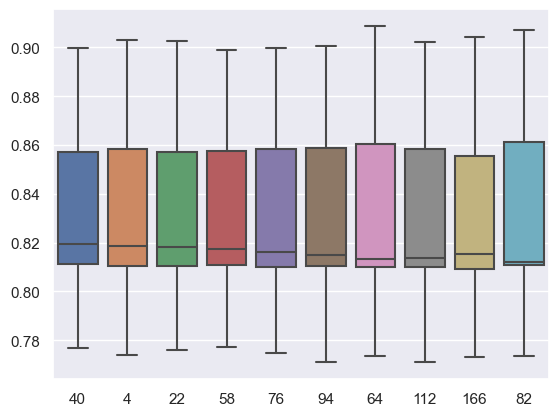

In [20]:
mask = grid_result.index[grid_result.index.str.endswith("_test_score")][:-3]
tabl = grid_result.loc[mask].iloc[:,:10]
sns.boxplot(data=tabl);

In [21]:
grid.best_params_

{'classifier': KNeighborsClassifier(n_neighbors=92, p=1, weights='distance'),
 'classifier__n_neighbors': 92,
 'classifier__p': 1,
 'classifier__weights': 'distance',
 'preprocessing': StandardScaler()}

In [22]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('classifier',    KNeighborsClassifier(n_neighbors=106,
                                                        p = 1,
                                                        weights='distance'))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

#это метрики при данном количестве соседей, но порог принятия решения не оптимизирован
print(f'precision:     {precision_score(y_test, y_pred)}')
print(f'recall:        {recall_score(y_test, y_pred)}')
print(f'f1:            {f1_score(y_test, y_pred)}')
print(f'roc_auc:       {roc_auc_score(y_test, y_pred)} \n')
print(classification_report(y_test, y_pred))

precision:     0.6781609195402298
recall:        0.6344086021505376
f1:            0.6555555555555556
roc_auc:       0.7328669516776785 

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       332
           1       0.68      0.63      0.66       186

    accuracy                           0.76       518
   macro avg       0.74      0.73      0.74       518
weighted avg       0.76      0.76      0.76       518



In [23]:
best_score = -1
threshold_best = -1
y_pred_proba = pipe.predict_proba(X_test)[:,1]

#попытаемся подвигать порог в сторону увеличения пресижн
for threshold in np.unique(pipe.predict_proba(X_test)[:,1]):
        y_pred = (y_pred_proba > threshold).astype(int)
        scr = fbeta_score(y_test, y_pred, beta = 0.1)
        if scr > best_score:
            best_score = scr
            threshold_best = threshold
print(f'Treshold: {threshold_best}') # этот порог берем в модель

Treshold: 0.7616942898478744


In [24]:
y_pred = (y_pred_proba > threshold_best).astype(int)

print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))
print('fbeta', fbeta_score(y_test, y_pred, beta = 0.4))
print('ROC AUC', roc_auc_score(y_test, y_pred))

#финальные метрики

precision 1.0
recall 0.07526881720430108
fbeta 0.3711151736745887
ROC AUC 0.5376344086021505


### Попробуем logreg

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.datasets import load_iris

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import RobustScaler, Normalizer

from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.model_selection import GridSearchCV, KFold, StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

import sklearn
print(sklearn.__version__)

1.2.1


In [26]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           LogisticRegression())])

cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 10)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling,'clf__penalty': ['l2'], 
         'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga'],
          'clf__C' : [0.1, 0.3, 0.5, 0.7, 0.8, 1, 1.1, 1.3, 1.5]},
    {'preprocessing': scaling,'clf__penalty': ['l1'], 
         'clf__solver': ['liblinear','saga'],
          'clf__C' : [0.1, 0.3, 0.5, 0.7, 0.8, 1, 1.1, 1.3, 1.5]},
    {'preprocessing': scaling,'clf__penalty': ['none'], 
         'clf__solver': ['lbfgs','newton-cg','saga','sag'],
          'clf__C' : [0.1, 0.3, 0.5, 0.7, 0.8, 1, 1.1, 1.3, 1.5]},
    {'preprocessing': scaling,'clf__penalty': ['elasticnet'], 
         'clf__solver': ['saga'],
          'clf__C' : [0.1, 0.3, 0.5, 0.7, 0.8, 1, 1.1, 1.3, 1.5]}
    ]

grid = GridSearchCV(pipe, param_grid, cv = cv, scoring = 'roc_auc', return_train_score = True)
grid.fit(X_train, y_train)
grid    

C:\Users\fueir\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\fueir\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\fueir\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\fueir\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\fueir\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'clf__C': [0.1, 0.3, 0.5, 0.7, 0.8, 1, 1.1, 1.3, 1.5],
                          'clf__penalty': ['l2'],
                          'clf__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                          'sag', 'saga'],
                          'preprocessing': [Min...
                          'clf__penalty': ['none'],
                          'clf__solver': ['lbfgs', 'newton-cg', 'saga', 'sag'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]},
                         {'clf__C': [0.1, 0.3, 0.5, 0.7, 0.8, 1, 1.1, 1.3, 1.5],
                          'clf__penalty': ['elasticnet'],
                          'clf__solver': ['saga'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]}],
             return_train_score=True, scoring='roc_auc')

In [27]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,46,58,42,54,98,94,86,82,102,106,...,422,423,424,425,426,427,428,429,430,431
mean_fit_time,0.008731,0.01161,0.012419,0.007567,0.012908,0.009822,0.024438,0.021786,0.012808,0.008704,...,0.005105,0.003206,0.003388,0.004225,0.006562,0.004371,0.003989,0.003737,0.004816,0.003259
std_fit_time,0.000847,0.001273,0.00213,0.000775,0.001629,0.002044,0.018735,0.003112,0.001575,0.001463,...,0.000294,0.000399,0.000483,0.001939,0.001234,0.001301,0.000912,0.000662,0.000357,0.000389
mean_score_time,0.002531,0.002038,0.0027,0.001902,0.002827,0.002542,0.005295,0.004657,0.002942,0.002463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std_score_time,0.000649,0.000101,0.000458,0.000538,0.000406,0.000923,0.001211,0.000784,0.000769,0.000755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
param_clf__C,0.5,0.5,0.5,0.5,0.8,0.8,0.8,0.8,1,1,...,1.1,1.1,1.3,1.3,1.3,1.3,1.5,1.5,1.5,1.5
param_clf__penalty,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,...,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet
param_clf__solver,lbfgs,saga,newton-cg,sag,saga,sag,lbfgs,newton-cg,newton-cg,lbfgs,...,saga,saga,saga,saga,saga,saga,saga,saga,saga,saga
param_preprocessing,RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),...,RobustScaler(),Normalizer(),MinMaxScaler(),StandardScaler(),RobustScaler(),Normalizer(),MinMaxScaler(),StandardScaler(),RobustScaler(),Normalizer()
params,"{'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__so...","{'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__so...","{'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__so...","{'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__so...","{'clf__C': 0.8, 'clf__penalty': 'l2', 'clf__so...","{'clf__C': 0.8, 'clf__penalty': 'l2', 'clf__so...","{'clf__C': 0.8, 'clf__penalty': 'l2', 'clf__so...","{'clf__C': 0.8, 'clf__penalty': 'l2', 'clf__so...","{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...","{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",...,"{'clf__C': 1.1, 'clf__penalty': 'elasticnet', ...","{'clf__C': 1.1, 'clf__penalty': 'elasticnet', ...","{'clf__C': 1.3, 'clf__penalty': 'elasticnet', ...","{'clf__C': 1.3, 'clf__penalty': 'elasticnet', ...","{'clf__C': 1.3, 'clf__penalty': 'elasticnet', ...","{'clf__C': 1.3, 'clf__penalty': 'elasticnet', ...","{'clf__C': 1.5, 'clf__penalty': 'elasticnet', ...","{'clf__C': 1.5, 'clf__penalty': 'elasticnet', ...","{'clf__C': 1.5, 'clf__penalty': 'elasticnet', ...","{'clf__C': 1.5, 'clf__penalty': 'elasticnet', ..."
split0_test_score,0.830967,0.830934,0.830967,0.830967,0.831529,0.831529,0.831496,0.831463,0.831661,0.831661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


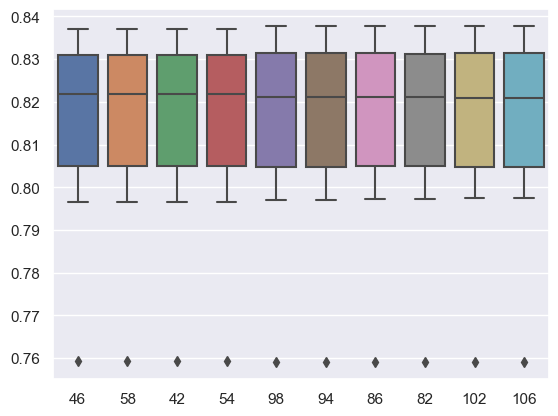

In [28]:
mask = grid_result.index[grid_result.index.str.endswith("_test_score")][:-3]
tabl = grid_result.loc[mask].iloc[:,:10]
sns.boxplot(data=tabl);

In [29]:
grid.best_params_

{'clf__C': 0.5,
 'clf__penalty': 'l2',
 'clf__solver': 'lbfgs',
 'preprocessing': RobustScaler()}

In [30]:
pipe_best = make_pipeline(RobustScaler(), LogisticRegression(solver = 'newton-cg', penalty = 'l2', C = 0.1) )

pipe_best.fit(X_train,y_train)

y_pred_best = pipe_best.predict(X_test)

print(f'precision:     {precision_score(y_test, y_pred_best)}')
print(f'recall:        {recall_score(y_test, y_pred_best)}')
print(f'f1:            {f1_score(y_test, y_pred_best)}')
print(f'roc_auc:       {roc_auc_score(y_test, y_pred_best)} \n')
print(classification_report(y_test, y_pred_best))

precision:     0.6776315789473685
recall:        0.553763440860215
f1:            0.6094674556213018
roc_auc:       0.7030865397072159 

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       332
           1       0.68      0.55      0.61       186

    accuracy                           0.75       518
   macro avg       0.73      0.70      0.71       518
weighted avg       0.74      0.75      0.74       518



Судя по всему, модель из метода соседей лучше модели logreg. 

Из всех метрик логичнее всего мерить по precision, так как именно так мы минимизируем попадание плохих вин в нашу коллекцию хорошего вина (то есть минимизируем FP)